************************************************************
 CAN BUS SECURITY ANALYZER - ANALYSIS SYSTEM VERSION
************************************************************

Processing CAN bus logs...

📈 Data Loading Summary:
Speed Injection: 11306 records
RPM Injection: 816 records
Baseline: 707 records

=== SPEED INJECTION DATA ===
   Speed    RPM  Attack
0    0.0  626.0       0
1    0.0  624.0       0
2    0.0  624.0       0
3    0.0  626.0       0
4    0.0  626.0       0

=== RPM INJECTION DATA ===
      Speed    RPM  Attack
0  5.312724  740.0       0
1  5.312724  742.0       0
2  5.312724  744.0       0
3  5.343792  744.0       0
4  5.343792  742.0       0

=== BASELINE DATA ===
   Speed    RPM  Attack
0    0.0  636.0       0
1    0.0  640.0       0
2    0.0  640.0       0
3    0.0  638.0       0
4    0.0  638.0       0


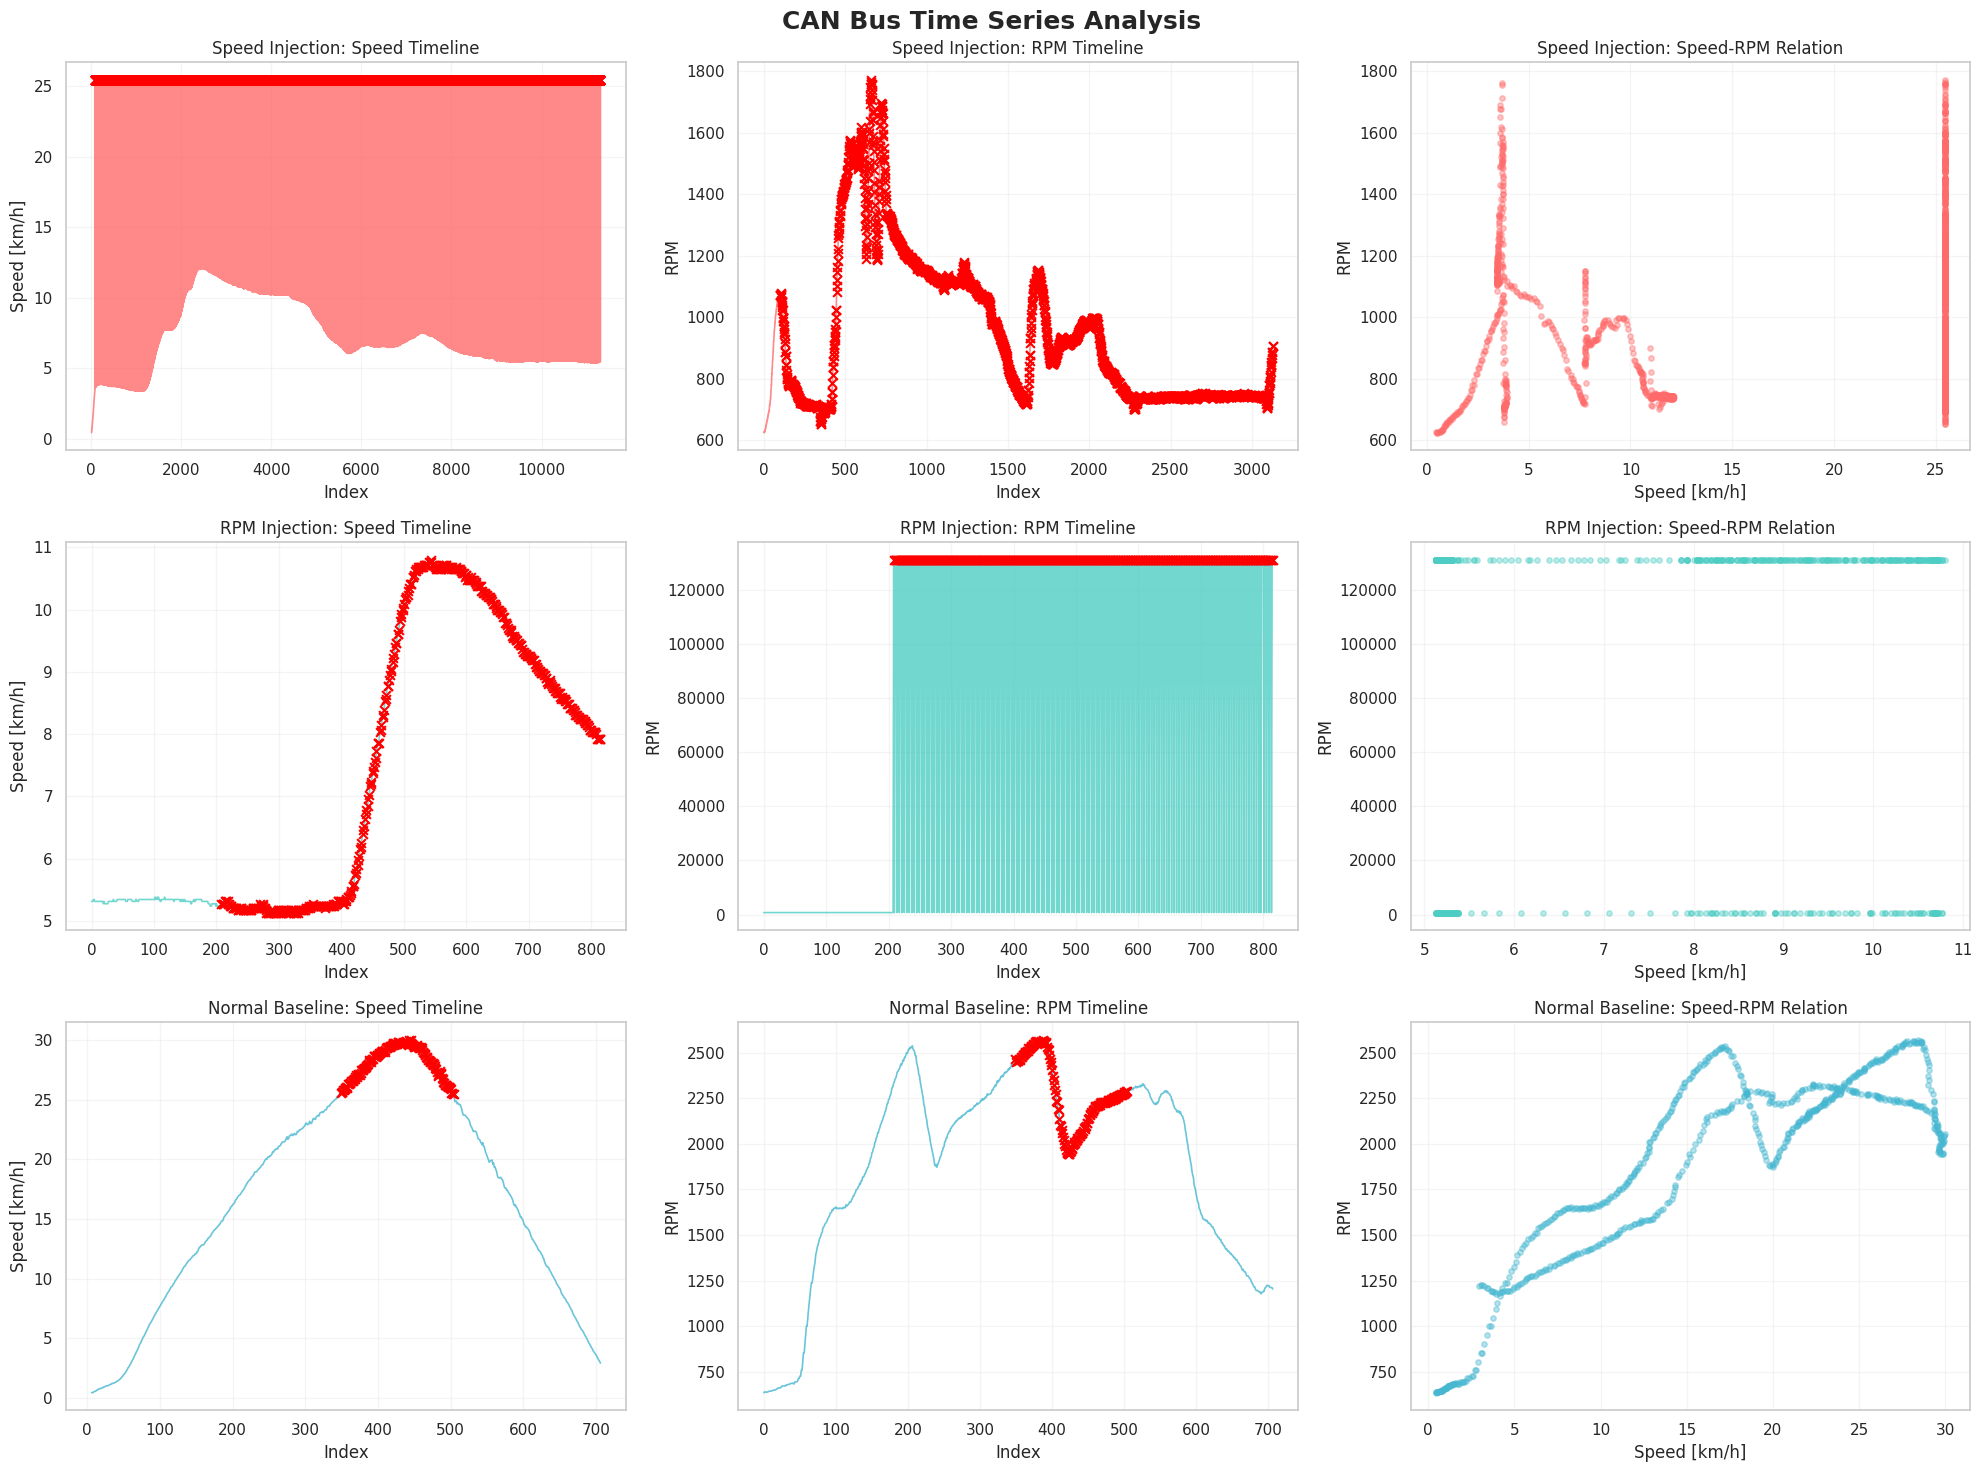

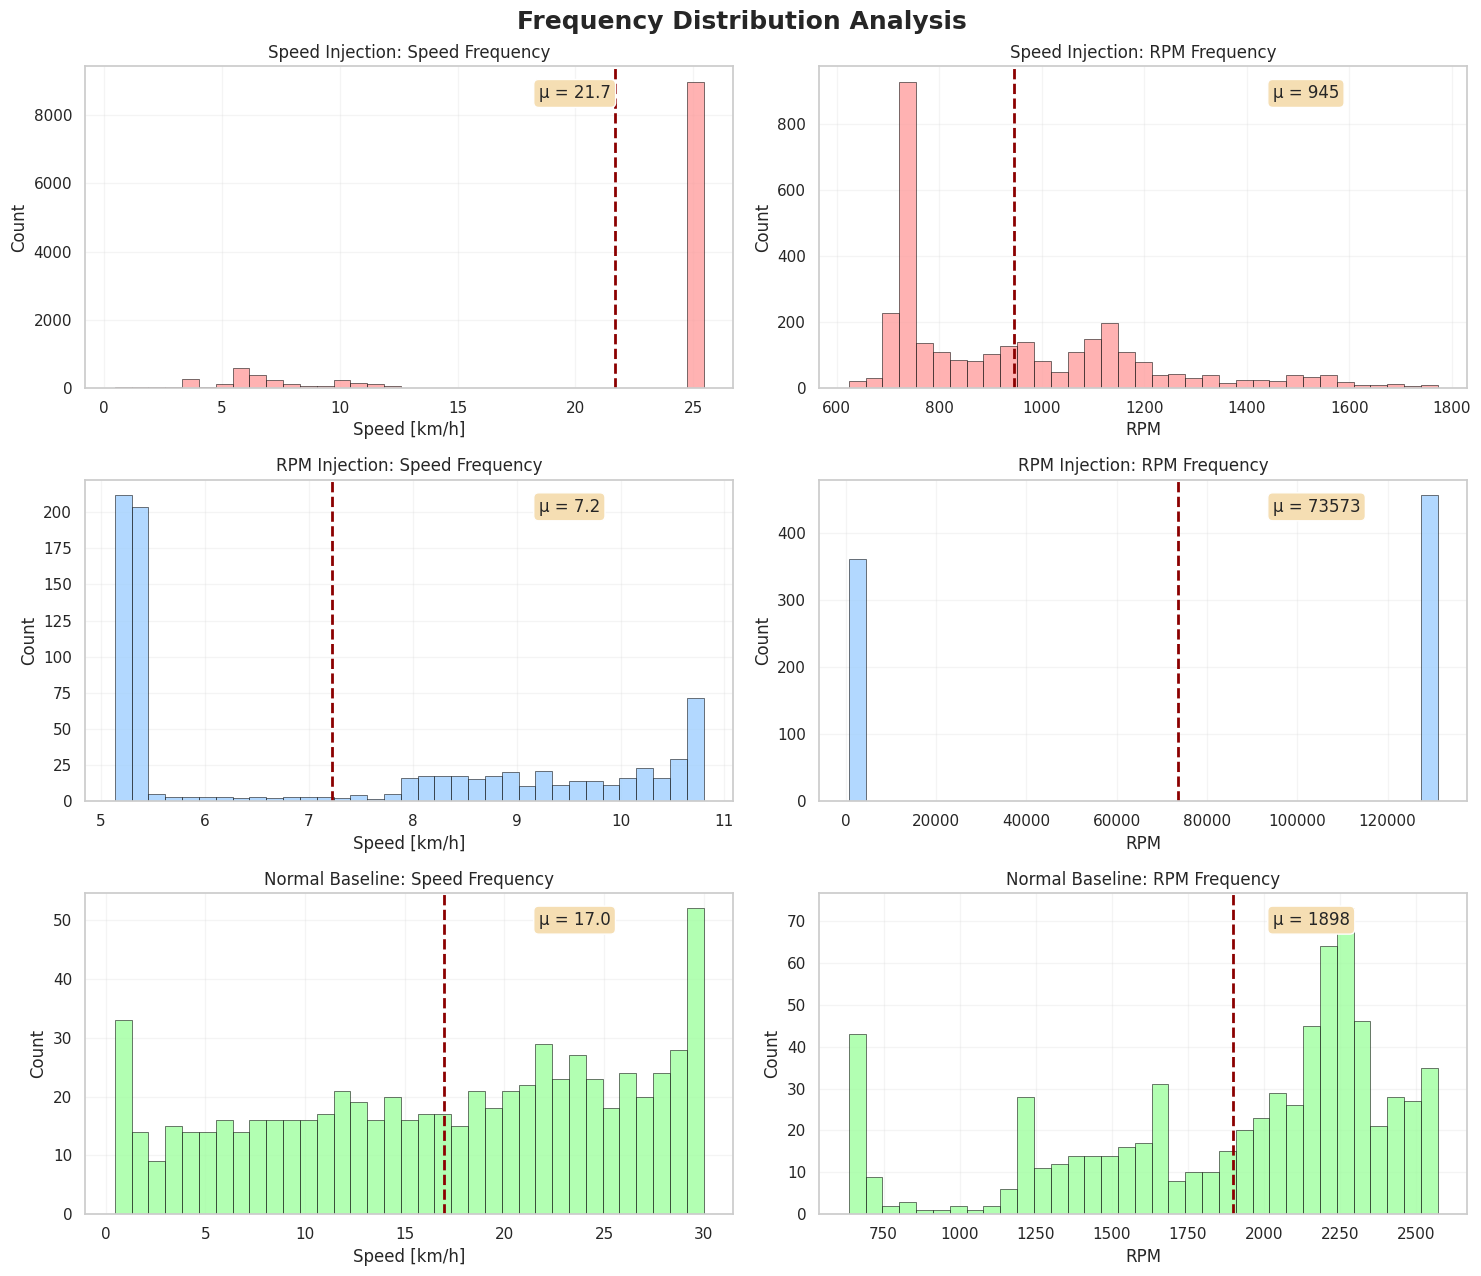


************************************************************
 CORRELATION ANALYSIS RESULTS
************************************************************

Speed Injection:
  Correlation coefficient: -0.008159
  P-value: 6.48e-01
  Sample size: 3129
  Strength: Weak
  Significant: No

RPM Injection:
  Correlation coefficient: 0.334291
  P-value: 9.37e-23
  Sample size: 816
  Strength: Moderate
  Significant: Yes

Normal Baseline:
  Correlation coefficient: 0.860268
  P-value: 1.10e-206
  Sample size: 701
  Strength: Strong
  Significant: Yes

************************************************************
 CORRELATION SUMMARY TABLE
************************************************************
       Scenario  Correlation_Coeff       P_Value  N_Samples
Speed Injection          -0.008159  6.482316e-01       3129
  RPM Injection           0.334291  9.374616e-23        816
Normal Baseline           0.860268 1.103138e-206        701


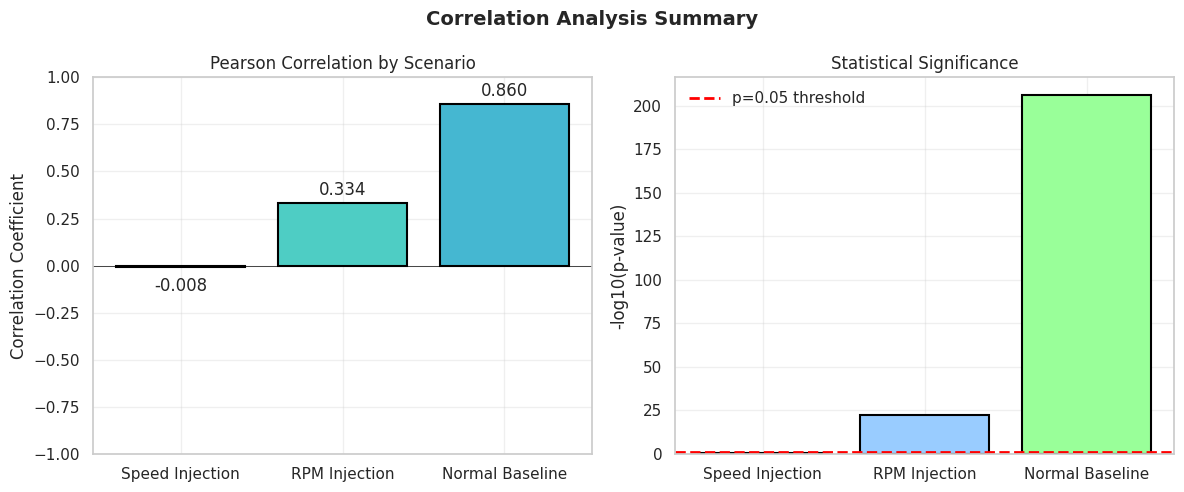


 ANALYSIS COMPLETE - FINAL STATISTICS

[1] Speed Injection:
    Total records: 11306
    Attack records: 8994
    Attack percentage: 79.55%
    Speed - Mean: 21.70, Std: 7.50
    RPM - Mean: 945.45, Std: 243.98

[2] RPM Injection:
    Total records: 816
    Attack records: 456
    Attack percentage: 55.88%
    Speed - Mean: 7.22, Std: 2.19
    RPM - Mean: 73573.33, Std: 64750.05

[3] Normal Baseline:
    Total records: 707
    Attack records: 156
    Attack percentage: 22.07%
    Speed - Mean: 16.98, Std: 8.90
    RPM - Mean: 1898.22, Std: 526.17

 END OF ANALYSIS


In [ ]:
# **************************************************************************
# CAN BUS AUTOMOTIVE SECURITY ANALYZER
# Version: AS (Analysis System)
# **************************************************************************

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import warnings

# Environment setup
warnings.simplefilter('ignore')
pd.set_option('display.width', 200)

# Graphics settings
plt.rcParams.update({'figure.facecolor': 'white', 'axes.facecolor': 'white'})
sns.set_theme(style="whitegrid")

print("*" * 60)
print(" CAN BUS SECURITY ANALYZER - ANALYSIS SYSTEM VERSION")
print("*" * 60)

# **************************************************************************
# TASK 1: DATA LOADING AND PROCESSING
# **************************************************************************

class CANProcessor_AS:
    """CAN message processor for analysis system"""

    def __init__(self):
        self.SPEED_CAN_AS = '254'
        self.RPM_CAN_AS = '115'
        self.SPEED_FACTOR_AS = 0.62137119 / 100
        self.RPM_FACTOR_AS = 2

    def parse_log_file_AS(self, filename_AS):
        """Parse CAN bus log file"""
        messages_AS = []

        try:
            with open(filename_AS, 'r') as log_AS:
                raw_lines_AS = log_AS.readlines()

            for line_num_AS, raw_line_AS in enumerate(raw_lines_AS):
                try:
                    parsed_AS = self.extract_message_AS(raw_line_AS)
                    if parsed_AS:
                        messages_AS.append(parsed_AS)
                except:
                    pass

        except FileNotFoundError:
            print(f"Error: File {filename_AS} not found")

        return messages_AS

    def extract_message_AS(self, line_AS):
        """Extract CAN message from line"""
        can_msg_AS = {}

        can_msg_AS['time_AS'] = line_AS[1:18].strip()
        can_msg_AS['id_AS'] = line_AS[25:28].strip()
        can_msg_AS['len_AS'] = line_AS[29:33].strip()
        can_msg_AS['bytes_AS'] = line_AS[33:41].strip()
        can_msg_AS['hex_val_AS'] = int(line_AS[41:45], 16)
        can_msg_AS['injected_AS'] = 0

        # Process speed messages
        if can_msg_AS['id_AS'] == self.SPEED_CAN_AS:
            if can_msg_AS['hex_val_AS'] >= 4095:
                can_msg_AS['injected_AS'] = 1
            can_msg_AS['hex_val_AS'] *= self.SPEED_FACTOR_AS

        # Process RPM messages
        elif can_msg_AS['id_AS'] == self.RPM_CAN_AS:
            if can_msg_AS['hex_val_AS'] >= 65535:
                can_msg_AS['injected_AS'] = 1
            can_msg_AS['hex_val_AS'] *= self.RPM_FACTOR_AS

        return can_msg_AS

    def create_dataframe_AS(self, messages_AS):
        """Convert messages to DataFrame"""
        df_temp_AS = pd.DataFrame(messages_AS)

        # Filter for speed and RPM only
        filter_AS = df_temp_AS['id_AS'].isin([self.SPEED_CAN_AS, self.RPM_CAN_AS])
        df_filt_AS = df_temp_AS[filter_AS].copy()

        # Separate speed and RPM
        speed_rows_AS = df_filt_AS[df_filt_AS['id_AS'] == self.SPEED_CAN_AS]
        rpm_rows_AS = df_filt_AS[df_filt_AS['id_AS'] == self.RPM_CAN_AS]

        # Create output DataFrame
        output_AS = pd.DataFrame()

        # Add speed column
        output_AS['Speed'] = speed_rows_AS['hex_val_AS'].reset_index(drop=True)

        # Add RPM column
        output_AS['RPM'] = rpm_rows_AS['hex_val_AS'].reset_index(drop=True)

        # Add attack indicator
        attacks_speed_AS = speed_rows_AS['injected_AS'].reset_index(drop=True)
        attacks_rpm_AS = rpm_rows_AS['injected_AS'].reset_index(drop=True)

        output_AS['Attack'] = pd.concat([attacks_speed_AS, attacks_rpm_AS]).groupby(level=0).max()

        # Handle missing values
        output_AS.fillna(0, inplace=True)

        return output_AS

# Initialize processor
processor_AS = CANProcessor_AS()

print("\nProcessing CAN bus logs...")

# Load speed attack data
speed_attack_msgs_AS = processor_AS.parse_log_file_AS(
    "CAN Bus log - injection of FFF as the speed reading.log"
)
df_speed_inj_AS = processor_AS.create_dataframe_AS(speed_attack_msgs_AS)

# Load RPM attack data
rpm_attack_msgs_AS = processor_AS.parse_log_file_AS(
    "CAN Bus log - injection of RPM readings.log"
)
df_rpm_inj_AS = processor_AS.create_dataframe_AS(rpm_attack_msgs_AS)

# Load normal data
normal_msgs_AS = processor_AS.parse_log_file_AS(
    "CAN bus log - no injection of messages.log"
)
df_baseline_AS = processor_AS.create_dataframe_AS(normal_msgs_AS)

print("\n📈 Data Loading Summary:")
print(f"Speed Injection: {len(df_speed_inj_AS)} records")
print(f"RPM Injection: {len(df_rpm_inj_AS)} records")
print(f"Baseline: {len(df_baseline_AS)} records")

# Show data samples
print("\n=== SPEED INJECTION DATA ===")
print(df_speed_inj_AS.head())
print("\n=== RPM INJECTION DATA ===")
print(df_rpm_inj_AS.head())
print("\n=== BASELINE DATA ===")
print(df_baseline_AS.head())

# **************************************************************************
# TASK 2.1: TIME SERIES VISUALIZATION
# **************************************************************************

def create_time_plots_AS(data_sets_AS, labels_AS):
    """Create time series plots"""

    figure_AS = plt.figure(figsize=(20, 15))
    figure_AS.suptitle('CAN Bus Time Series Analysis', size=18, weight='bold')

    plot_colors_AS = ['#FF6B6B', '#4ECDC4', '#45B7D1']

    for idx_AS, (frame_AS, label_AS, col_AS) in enumerate(zip(data_sets_AS, labels_AS, plot_colors_AS)):

        # Clean data
        speed_nums_AS = pd.to_numeric(frame_AS['Speed'], errors='coerce')
        rpm_nums_AS = pd.to_numeric(frame_AS['RPM'], errors='coerce')

        # Plot 1: Speed timeline
        subplot1_AS = plt.subplot(3, 3, idx_AS * 3 + 1)
        valid_speed_AS = speed_nums_AS > 0

        if valid_speed_AS.sum() > 0:
            indices_speed_AS = valid_speed_AS[valid_speed_AS].index
            values_speed_AS = speed_nums_AS[valid_speed_AS]

            subplot1_AS.plot(indices_speed_AS, values_speed_AS,
                           color=col_AS, linewidth=1.2, alpha=0.8)

            # Highlight attacks
            attack_points_AS = (valid_speed_AS) & (frame_AS['Attack'] == 1)
            if attack_points_AS.sum() > 0:
                subplot1_AS.scatter(attack_points_AS[attack_points_AS].index,
                                  speed_nums_AS[attack_points_AS],
                                  color='red', marker='x', s=40, zorder=10)

        subplot1_AS.set_title(f'{label_AS}: Speed Timeline', fontsize=12)
        subplot1_AS.set_xlabel('Index')
        subplot1_AS.set_ylabel('Speed [km/h]')
        subplot1_AS.grid(True, alpha=0.2)

        # Plot 2: RPM timeline
        subplot2_AS = plt.subplot(3, 3, idx_AS * 3 + 2)
        valid_rpm_AS = rpm_nums_AS > 0

        if valid_rpm_AS.sum() > 0:
            indices_rpm_AS = valid_rpm_AS[valid_rpm_AS].index
            values_rpm_AS = rpm_nums_AS[valid_rpm_AS]

            subplot2_AS.plot(indices_rpm_AS, values_rpm_AS,
                           color=col_AS, linewidth=1.2, alpha=0.8)

            # Highlight attacks
            attack_rpm_AS = (valid_rpm_AS) & (frame_AS['Attack'] == 1)
            if attack_rpm_AS.sum() > 0:
                subplot2_AS.scatter(attack_rpm_AS[attack_rpm_AS].index,
                                  rpm_nums_AS[attack_rpm_AS],
                                  color='red', marker='x', s=40, zorder=10)

        subplot2_AS.set_title(f'{label_AS}: RPM Timeline', fontsize=12)
        subplot2_AS.set_xlabel('Index')
        subplot2_AS.set_ylabel('RPM')
        subplot2_AS.grid(True, alpha=0.2)

        # Plot 3: Correlation plot
        subplot3_AS = plt.subplot(3, 3, idx_AS * 3 + 3)

        if valid_speed_AS.sum() > 0 and valid_rpm_AS.sum() > 0:
            n_points_AS = min(valid_speed_AS.sum(), valid_rpm_AS.sum())
            speed_pts_AS = speed_nums_AS[valid_speed_AS].iloc[:n_points_AS]
            rpm_pts_AS = rpm_nums_AS[valid_rpm_AS].iloc[:n_points_AS]

            subplot3_AS.scatter(speed_pts_AS, rpm_pts_AS,
                              color=col_AS, alpha=0.4, s=15)

        subplot3_AS.set_title(f'{label_AS}: Speed-RPM Relation', fontsize=12)
        subplot3_AS.set_xlabel('Speed [km/h]')
        subplot3_AS.set_ylabel('RPM')
        subplot3_AS.grid(True, alpha=0.2)

    plt.tight_layout()
    plt.show()

# Create time plots
all_data_AS = [df_speed_inj_AS, df_rpm_inj_AS, df_baseline_AS]
all_labels_AS = ['Speed Injection', 'RPM Injection', 'Normal Baseline']
create_time_plots_AS(all_data_AS, all_labels_AS)

# **************************************************************************
# TASK 2.2: DISTRIBUTION ANALYSIS
# **************************************************************************

def create_histograms_AS(data_sets_AS, labels_AS):
    """Create distribution histograms"""

    figure_AS = plt.figure(figsize=(15, 13))
    figure_AS.suptitle('Frequency Distribution Analysis', size=18, weight='bold')

    hist_colors_AS = ['#FF9999', '#99CCFF', '#99FF99']

    for row_AS, (frame_AS, label_AS, hcol_AS) in enumerate(zip(data_sets_AS, labels_AS, hist_colors_AS)):

        # Clean data
        speed_nums_AS = pd.to_numeric(frame_AS['Speed'], errors='coerce')
        rpm_nums_AS = pd.to_numeric(frame_AS['RPM'], errors='coerce')

        # Speed histogram
        ax_speed_AS = plt.subplot(3, 2, row_AS * 2 + 1)
        speed_positive_AS = speed_nums_AS[speed_nums_AS > 0].dropna()

        if len(speed_positive_AS) > 0:
            ax_speed_AS.hist(speed_positive_AS, bins=35,
                           color=hcol_AS, edgecolor='black',
                           linewidth=0.5, alpha=0.75)

            mean_speed_AS = speed_positive_AS.mean()
            ax_speed_AS.axvline(mean_speed_AS, color='darkred',
                              linestyle='--', linewidth=2)
            ax_speed_AS.text(0.7, 0.9, f'μ = {mean_speed_AS:.1f}',
                           transform=ax_speed_AS.transAxes,
                           bbox=dict(boxstyle='round', facecolor='wheat'))

        ax_speed_AS.set_title(f'{label_AS}: Speed Frequency')
        ax_speed_AS.set_xlabel('Speed [km/h]')
        ax_speed_AS.set_ylabel('Count')
        ax_speed_AS.grid(True, alpha=0.2)

        # RPM histogram
        ax_rpm_AS = plt.subplot(3, 2, row_AS * 2 + 2)
        rpm_positive_AS = rpm_nums_AS[rpm_nums_AS > 0].dropna()

        if len(rpm_positive_AS) > 0:
            ax_rpm_AS.hist(rpm_positive_AS, bins=35,
                         color=hcol_AS, edgecolor='black',
                         linewidth=0.5, alpha=0.75)

            mean_rpm_AS = rpm_positive_AS.mean()
            ax_rpm_AS.axvline(mean_rpm_AS, color='darkred',
                            linestyle='--', linewidth=2)
            ax_rpm_AS.text(0.7, 0.9, f'μ = {mean_rpm_AS:.0f}',
                         transform=ax_rpm_AS.transAxes,
                         bbox=dict(boxstyle='round', facecolor='wheat'))

        ax_rpm_AS.set_title(f'{label_AS}: RPM Frequency')
        ax_rpm_AS.set_xlabel('RPM')
        ax_rpm_AS.set_ylabel('Count')
        ax_rpm_AS.grid(True, alpha=0.2)

    plt.tight_layout()
    plt.show()

# Create histograms
create_histograms_AS(all_data_AS, all_labels_AS)

# **************************************************************************
# TASK 2.3: STATISTICAL CORRELATION
# **************************************************************************

def compute_correlations_AS(data_sets_AS, labels_AS):
    """Compute Pearson correlations"""

    correlation_table_AS = []

    print("\n" + "*"*60)
    print(" CORRELATION ANALYSIS RESULTS")
    print("*"*60)

    for frame_AS, label_AS in zip(data_sets_AS, labels_AS):

        # Clean data
        speed_nums_AS = pd.to_numeric(frame_AS['Speed'], errors='coerce')
        rpm_nums_AS = pd.to_numeric(frame_AS['RPM'], errors='coerce')

        # Filter positive values
        speed_pos_AS = speed_nums_AS[speed_nums_AS > 0].dropna()
        rpm_pos_AS = rpm_nums_AS[rpm_nums_AS > 0].dropna()

        # Match lengths
        n_samples_AS = min(len(speed_pos_AS), len(rpm_pos_AS))

        if n_samples_AS > 2:
            speed_array_AS = speed_pos_AS.iloc[:n_samples_AS].values
            rpm_array_AS = rpm_pos_AS.iloc[:n_samples_AS].values

            # Compute Pearson
            r_value_AS, p_value_AS = pearsonr(speed_array_AS, rpm_array_AS)

            correlation_table_AS.append({
                'Scenario': label_AS,
                'Correlation_Coeff': r_value_AS,
                'P_Value': p_value_AS,
                'N_Samples': n_samples_AS
            })
            print(f"\n{label_AS}:")
            print(f"  Correlation coefficient: {r_value_AS:.6f}")
            print(f"  P-value: {p_value_AS:.2e}")
            print(f"  Sample size: {n_samples_AS}")

            # Interpret correlation
            if abs(r_value_AS) < 0.3:
                strength_AS = "Weak"
            elif abs(r_value_AS) < 0.7:
                strength_AS = "Moderate"
            else:
                strength_AS = "Strong"

            print(f"  Strength: {strength_AS}")
            print(f"  Significant: {'Yes' if p_value_AS < 0.05 else 'No'}")

    return pd.DataFrame(correlation_table_AS)

# Compute correlations
results_df_AS = compute_correlations_AS(all_data_AS, all_labels_AS)

print("\n" + "*"*60)
print(" CORRELATION SUMMARY TABLE")
print("*"*60)
print(results_df_AS.to_string(index=False))

# **************************************************************************
# VISUALIZATION OF CORRELATION RESULTS
# **************************************************************************

def visualize_correlations_AS(results_AS):
    """Create correlation visualization"""

    fig_corr_AS, axes_corr_AS = plt.subplots(1, 2, figsize=(12, 5))
    fig_corr_AS.suptitle('Correlation Analysis Summary', fontsize=14, weight='bold')

    # Bar chart of correlations
    ax1_AS = axes_corr_AS[0]
    scenarios_AS = results_AS['Scenario']
    correlations_AS = results_AS['Correlation_Coeff']

    bars_AS = ax1_AS.bar(scenarios_AS, correlations_AS,
                         color=['#FF6B6B', '#4ECDC4', '#45B7D1'],
                         edgecolor='black', linewidth=1.5)

    ax1_AS.set_ylabel('Correlation Coefficient')
    ax1_AS.set_ylim(-1, 1)
    ax1_AS.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax1_AS.grid(True, alpha=0.3)
    ax1_AS.set_title('Pearson Correlation by Scenario')

    # Add value labels
    for bar_AS, val_AS in zip(bars_AS, correlations_AS):
        height_AS = bar_AS.get_height()
        ax1_AS.text(bar_AS.get_x() + bar_AS.get_width()/2.,
                   height_AS + 0.02 if height_AS >= 0 else height_AS - 0.05,
                   f'{val_AS:.3f}', ha='center', va='bottom' if height_AS >= 0 else 'top')

    # P-value chart
    ax2_AS = axes_corr_AS[1]
    pvalues_AS = results_AS['P_Value']

    bars2_AS = ax2_AS.bar(scenarios_AS, -np.log10(pvalues_AS),
                          color=['#FF9999', '#99CCFF', '#99FF99'],
                          edgecolor='black', linewidth=1.5)

    ax2_AS.axhline(y=-np.log10(0.05), color='red', linestyle='--',
                   linewidth=2, label='p=0.05 threshold')
    ax2_AS.set_ylabel('-log10(p-value)')
    ax2_AS.set_title('Statistical Significance')
    ax2_AS.legend()
    ax2_AS.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Visualize correlation results
visualize_correlations_AS(results_df_AS)

# **************************************************************************
# FINAL SUMMARY STATISTICS
# **************************************************************************

print("\n" + "="*60)
print(" ANALYSIS COMPLETE - FINAL STATISTICS")
print("="*60)

for idx_AS, (data_AS, label_AS) in enumerate(zip(all_data_AS, all_labels_AS)):
    print(f"\n[{idx_AS+1}] {label_AS}:")
    print(f"    Total records: {len(data_AS)}")
    print(f"    Attack records: {data_AS['Attack'].sum()}")
    print(f"    Attack percentage: {(data_AS['Attack'].sum()/len(data_AS)*100):.2f}%")

    # Get valid data
    speed_valid_AS = pd.to_numeric(data_AS['Speed'], errors='coerce')
    rpm_valid_AS = pd.to_numeric(data_AS['RPM'], errors='coerce')

    speed_clean_AS = speed_valid_AS[speed_valid_AS > 0].dropna()
    rpm_clean_AS = rpm_valid_AS[rpm_valid_AS > 0].dropna()

    if len(speed_clean_AS) > 0:
        print(f"    Speed - Mean: {speed_clean_AS.mean():.2f}, Std: {speed_clean_AS.std():.2f}")

    if len(rpm_clean_AS) > 0:
        print(f"    RPM - Mean: {rpm_clean_AS.mean():.2f}, Std: {rpm_clean_AS.std():.2f}")

print("\n" + "="*60)
print(" END OF ANALYSIS")
print("="*60)